# Experimenting with pixel level classification of snow
Here we are using the Copernicus Scene Classification Label (SCL) as ground truth (GT).  To what extent can we reverse engineer the algoritmically defined SCL with simple machine learning?

In [6]:
import numpy as np
import pathlib
import glob
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import xarray as xr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, confusion_matrix

In [90]:
# Band meanings
bandMeanings = {
    0: "Coastal Aerosol",
    1: "Blue",
    2: "Green",
    3: "Red",
    4: "Vegetation Red Edge 1",
    5: "Vegetation Red Edge 2",
    6: "Vegetation Red Edge 3",
    7: "Near-Infrared",
    8: "Narrow Near-Infrared",
    9: "Water Vapor",
    10: "Cirrus",
    11: "Shortwave Infrared 1",
    12: "Shortwave Infrared 2"
}

# In the xarray dataset, all bands are now named
# Define here the band names which we want to use as features
# Just print(ds) to see the band names in the dataset, which is loaded a bit lower down

feature_bands = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B09",
    "B10",
    "B11",
    "B12",
    "Elevation",  # Easy to add or remove new features now like elevation
    "Gradient_lon",
    "Gradient_lat",
]

In [91]:
# Lets build a pattern vector , n by m, where n=total number of pixels and m=13, form the L1C data
# Simultaneously read the snow GT from the L2A data

# New data load code here
# New data available at https://drive.google.com/drive/folders/1rVl_WCC8GxNiKkr_Sa2N8Oac0kMQWU_Y?usp=drive_link
# We have a single .nc file for each patch, for each year

base_path = '/home/murray/Projects/Scottish_Snow/output/downloads/netcdf'  # Replace with path for folder with all .nc files
glob_string = base_path + r'/*.nc'
print(glob_string)
data_list = sorted(list(glob.glob(glob_string)))
print(len(data_list))  # Should give 11 patches x 6 years = 66 files

/home/murray/Projects/Scottish_Snow/output/downloads/netcdf/*.nc
66


In [92]:
print(xr.open_dataset(data_list[0]))

<xarray.Dataset>
Dimensions:       (t: 59, x: 146, y: 155)
Coordinates:
    lon           (x, y) float64 ...
    lat           (x, y) float64 ...
    date          (t) datetime64[ns] ...
Dimensions without coordinates: t, x, y
Data variables: (12/19)
    B01           (t, x, y) int16 ...
    B02           (t, x, y) int16 ...
    B03           (t, x, y) int16 ...
    B04           (t, x, y) int16 ...
    B05           (t, x, y) int16 ...
    B06           (t, x, y) int16 ...
    ...            ...
    SCL           (t, x, y) int16 ...
    SNW           (t, x, y) int16 ...
    CLD           (t, x, y) int16 ...
    Elevation     (x, y) float32 ...
    Gradient_lon  (x, y) float32 ...
    Gradient_lat  (x, y) float32 ...
Attributes:
    description:  Sentinel L1C, L2A, and DEM data
    patchname:    An_Riabhachan


In [94]:

def build_feats_and_gt_lists(max_cloud_cover_pc=50, sample_rate=0.01, verbose=True):
    # Return a tuple of corresponding lists:
    # 1: list of file paths of l1c (13 band) data
    # 2: list dataframes, each with one row per-pixel, columns for features (13) + 3 GT related columns
    path_list = []
    df_list = []
    for filename in data_list:
        ds = xr.open_dataset(filename)

        # New procedure to drop dates with cloud cover over threshold
        grouped_by_date = ds["CLD"].groupby('date')
        average_cld_by_date = grouped_by_date.mean(dim=["x", "y"])
        dates_above_threshold = average_cld_by_date > max_cloud_cover_pc
        filtered_ds = ds.sel(t=~dates_above_threshold)
        
        ds_features = ds[feature_bands]
        imStack = ds_features.to_array().values

        nb, nt, nx, ny = imStack.shape
        assert nb == 16

        featsOneIm = imStack.reshape(nb, nt * nx * ny)
        df = pd.DataFrame(featsOneIm.T, columns=feature_bands)

        # Load the GT bands
        gtIm = ds[["SCL", "SNW", "CLD"]].to_array().values
        assert gtIm.shape[1:] == imStack.shape[1:]
        
        df['SCL'] = gtIm[0, :, :, :].flatten()
        df['SnowProb'] = gtIm[1, :, :,:].flatten()   
        df['CloudProb'] = gtIm[2, ...].flatten()

        # Add column with patch name
        df["patchname"] = ds.attrs["patchname"]

        # Randomly take a subset of the remaining pixels to reduce size of dataset
        df = df.sample(frac=sample_rate)

        path_list += [filename]
        df_list += [df]
    return path_list, df_list

def test_build_feats_and_gt_lists():
    path_list, df_list = build_feats_and_gt_lists(max_cloud_cover_pc=50)
    print(f"\nFound {len(path_list)} patches.  Following is just one")
    print(path_list[0])
    print(df_list[0].describe())
    
test_build_feats_and_gt_lists()


Found 66 patches.  Following is just one
/home/murray/Projects/Scottish_Snow/output/downloads/netcdf/An_Riabhachan_2018.nc
                B01           B02           B03           B04           B05  \
count  13352.000000  13352.000000  13352.000000  13352.000000  13352.000000   
mean    4799.564941   4598.872559   4306.777344   4508.549316   4702.609863   
std     2321.994629   2398.143799   2291.151123   2497.180176   2401.592285   
min     1031.000000    685.000000    441.000000    250.000000    232.000000   
25%     2623.000000   2336.000000   2146.500000   2112.750000   2480.000000   
50%     5222.500000   5022.500000   4672.000000   4917.500000   5059.000000   
75%     6520.250000   6356.000000   5958.000000   6324.000000   6409.000000   
max    11938.000000  11656.000000  11455.000000  12215.000000  12384.000000   

                B06           B07           B08           B8A           B09  \
count  13352.000000  13352.000000  13352.000000  13352.000000  13352.000000   
mean  

### Meanings of SCL codes

0 - No data
1 - Saturated / Defective
2 - Dark Area Pixels
3 - Cloud Shadows
4 - Vegetation
5 - Bare Soils
6 - Water
7 - Clouds low probability / Unclassified
8 - Clouds medium probability
9 - Clouds high probability
10 - Cirrus
11 - Snow / Ice

Total #pixels: 904500, class counts: Counter({False: 884632, True: 19868})


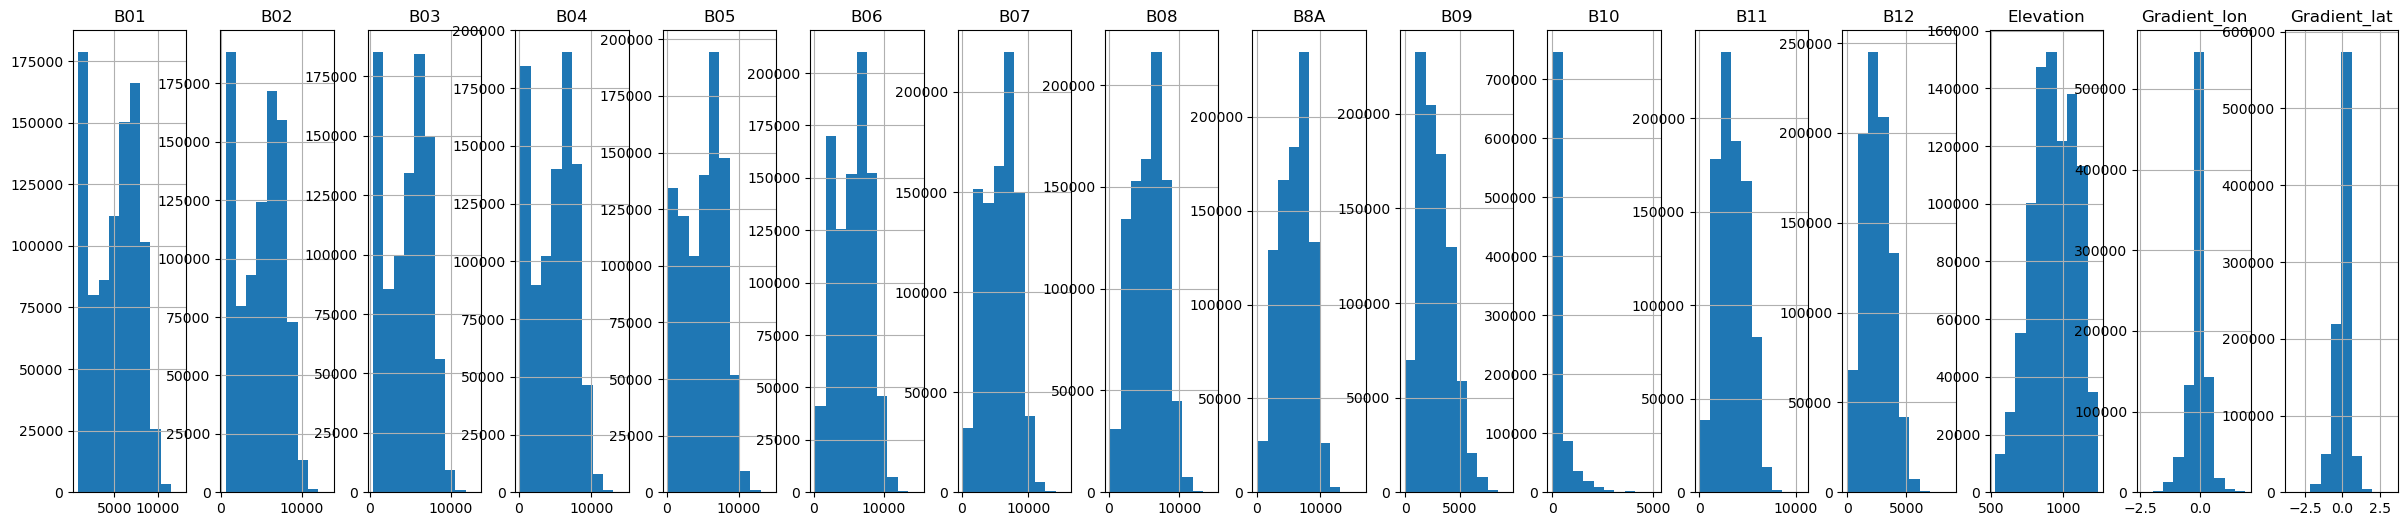

In [95]:
def build_total_df_and_gt(df_list):
    # Return a tuple:
    # X_df: a concatonated dataframe containing band information only, and 
    # y: a concatenated GT array
    # Thus X_df, y are ready to be fed to sklearn
    
    df_list_feats_only = [df.iloc[:, :16] for df in df_list]
    gt_list = [np.array(df['SCL']) for df in df_list]
    
    X_df = pd.concat(df_list_feats_only)
    y = np.hstack(gt_list)
    y = (y==11)   # 11 is "Snow"
    return X_df, y
    
def test_build_total_df_and_gt():
    path_list, df_list = build_feats_and_gt_lists(max_cloud_cover_pc=50)
    X_df, y = build_total_df_and_gt(df_list)
    print(f"Total #pixels: {len(X_df)}, class counts: {Counter(y)}")
    fig, axis = plt.subplots(1, 16, figsize=(30,6))
    X_df.hist(ax=axis)
    plt.show()
    assert len(X_df) == len(y)
    
test_build_total_df_and_gt()
    


## Split robustly on a patch basis

In [96]:
# Get a list of all the available top-level patch names
patch_names = list(set(xr.open_dataset(f).attrs["patchname"] for f in data_list))
patch_names

['Coire_Cruach_Sneachda',
 'Aonach_Beag',
 'Carn_na_Caim',
 'Gael_Charn',
 'Coire_Domhain',
 'An_Stuc',
 'An_Riabhachan',
 'Beinn_a_Bhuird',
 'Creag_Meagaidh',
 'Beinn_Mhanach',
 'Ciste_Mhearad']

In [97]:
# Assign patches roughly 2/3 : 1/3  train:test
cut_i = int(len(patch_names) * (2/3))
train_patches = patch_names[:cut_i]
test_patches = patch_names[cut_i:]
assert len(train_patches + test_patches) == len(patch_names)
train_patches, test_patches

(['Coire_Cruach_Sneachda',
  'Aonach_Beag',
  'Carn_na_Caim',
  'Gael_Charn',
  'Coire_Domhain',
  'An_Stuc',
  'An_Riabhachan'],
 ['Beinn_a_Bhuird', 'Creag_Meagaidh', 'Beinn_Mhanach', 'Ciste_Mhearad'])

In [98]:
def matches_list(p, patch_list):
    return any([pl in p for pl in patch_list])
    
def test_matches_list():
    patch_list = ['An_Stuc', 'Beinn_a_Bhuird']
    assert matches_list ('blah/An_Stuc/blah2234', patch_list)
    assert not matches_list('blah/Alps/blah564', patch_list)
test_matches_list()

In [109]:
path_list, df_list = build_feats_and_gt_lists(max_cloud_cover_pc=40, sample_rate=0.001)

train_path_list, train_df_list = list(zip(*[(path, df) for path, df in zip(path_list, df_list) if matches_list(path, train_patches)]))
test_path_list, test_df_list = list(zip(*[(path, df) for path, df in zip(path_list, df_list) if matches_list(path, test_patches)]))
assert len(train_df_list) + len(test_df_list) == len(df_list)
print(len(train_df_list), len(test_df_list), len(df_list))

42 24 66


Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220909T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220912T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220919T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220922T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220929T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220507T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220510T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220517T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220520T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220527T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220530T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_M

Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201907...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201907...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201907...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201907...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201907...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S

Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202106...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202106...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202107...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202107...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202107...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202107...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202107...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202108...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202108...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202108...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202108...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S

Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
No GT for ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018, skipping
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018

Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30

Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-3

Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-3

Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/

Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/

Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
No GT for ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018, skipping
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018

Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30

In [110]:
X_train, y_train = build_total_df_and_gt(train_df_list)
X_test, y_test = build_total_df_and_gt(test_df_list)

print(len(X_train), len(X_test))

57524 32927


In [111]:
# Setup a sklearn Pipeline
pipe = Pipeline([
    ("Scaling", StandardScaler()),
    #("Classifier", QuadraticDiscriminantAnalysis())
    ("Classifier", RandomForestClassifier())
])

cls = pipe.fit(np.array(X_train), y_train)

In [112]:
roc_auc_score(y_test, cls.predict_proba(np.array(X_test))[:,1])

0.9677637174858729

In [113]:
confusion_matrix(y_test, cls.predict(np.array(X_test)))

array([[32014,   130],
       [  620,   163]])

In [114]:
def RGBfromStack13(imStack):
    rgbIm = np.dstack((imStack[3, :,:], imStack[2, :,:], imStack[1, :,:]))
    rgbIm = 3.5 * rgbIm / 10000
    rgbIm = rgbIm.clip(0, 1)
    return rgbIm

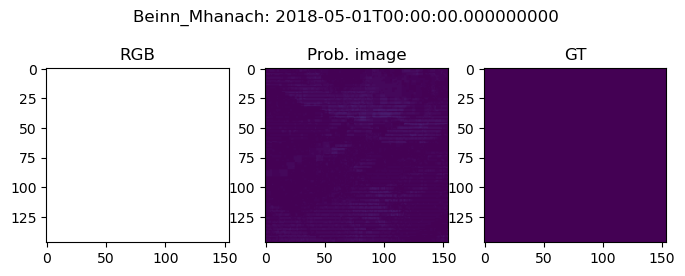

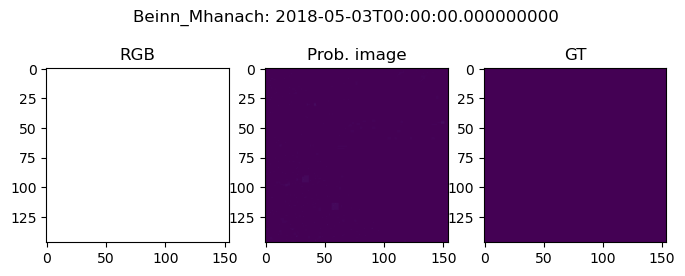

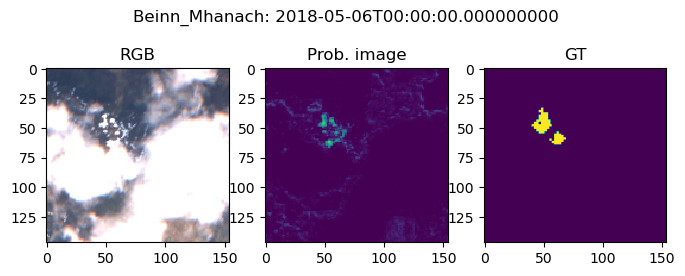

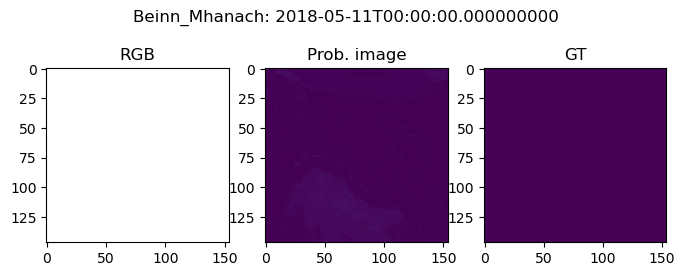

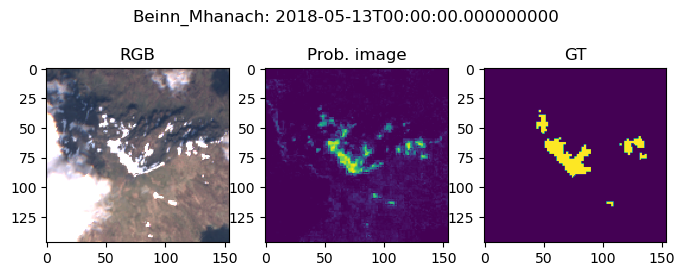

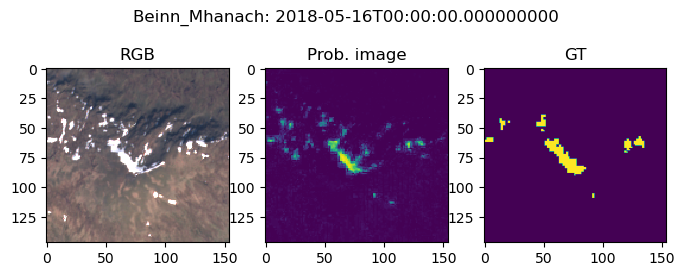

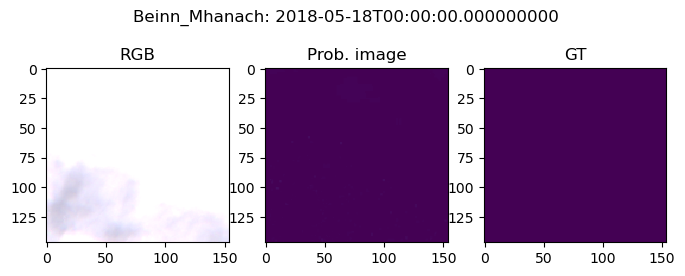

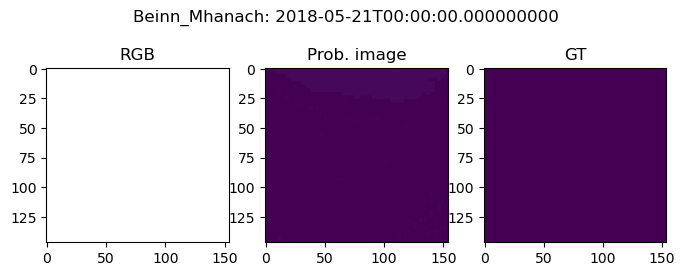

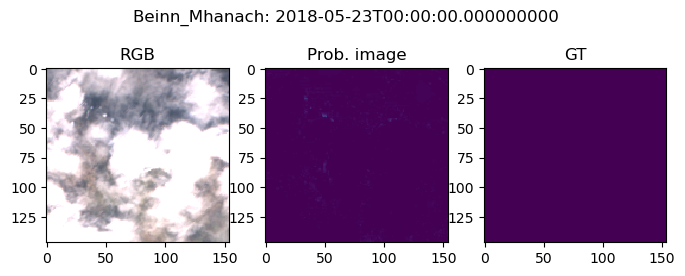

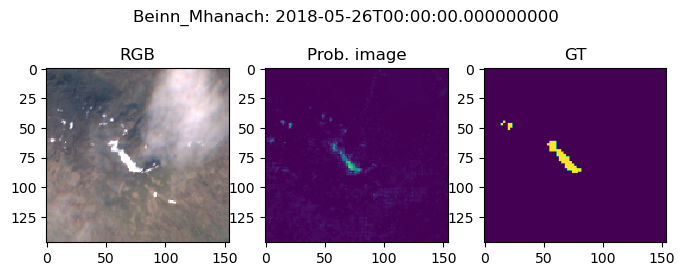

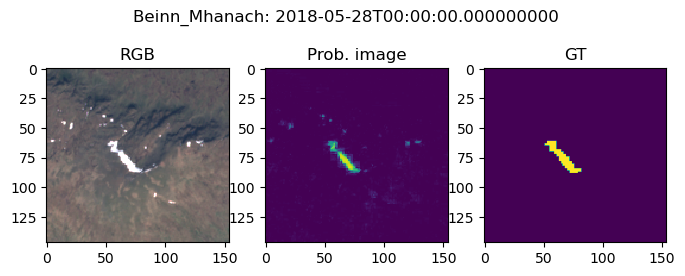

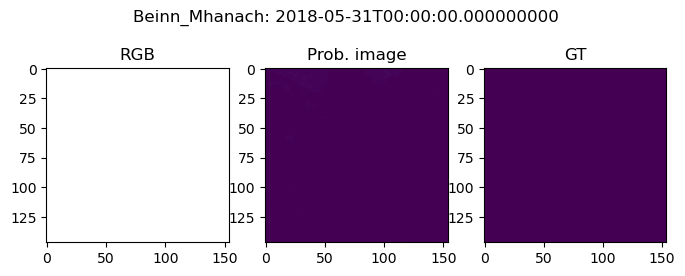

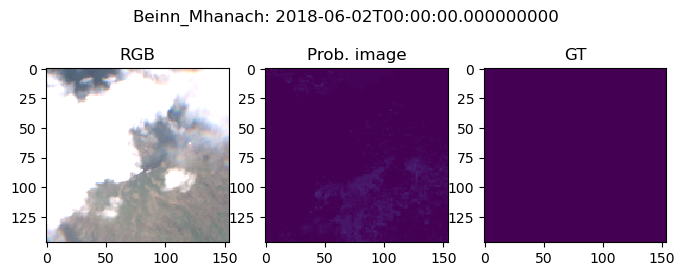

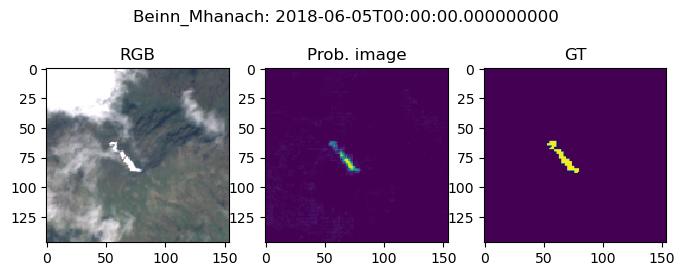

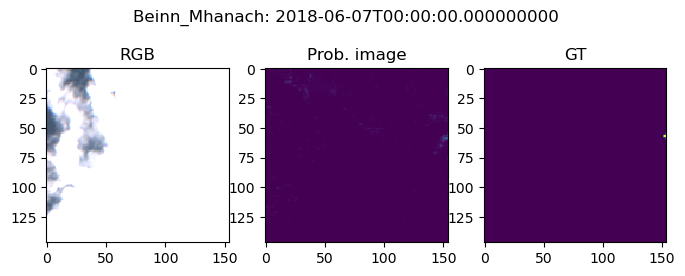

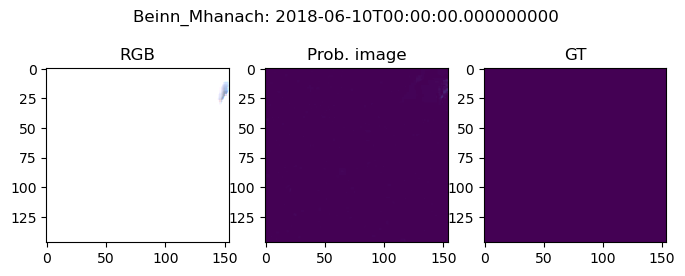

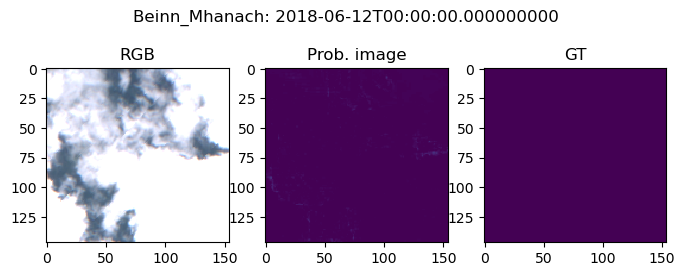

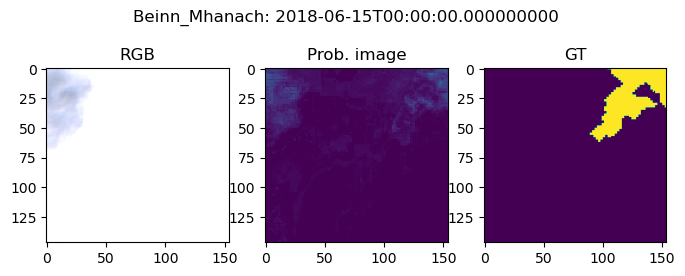

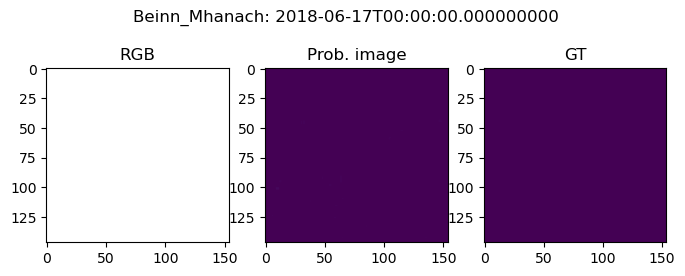

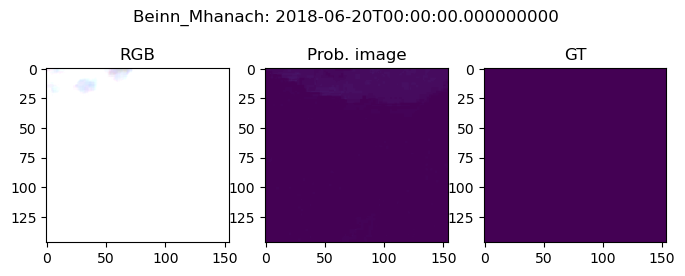

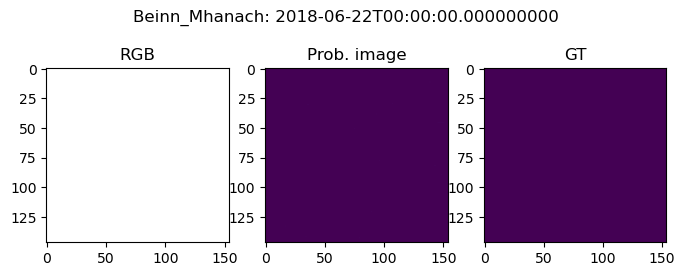

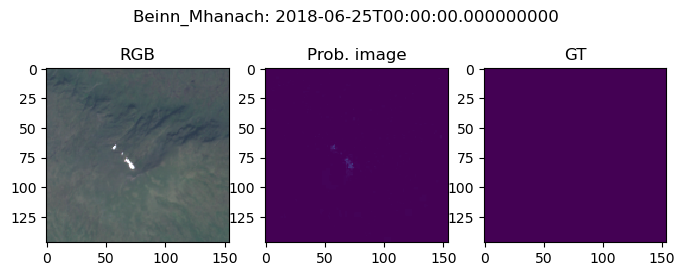

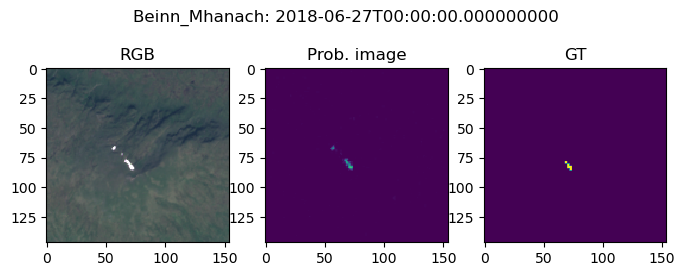

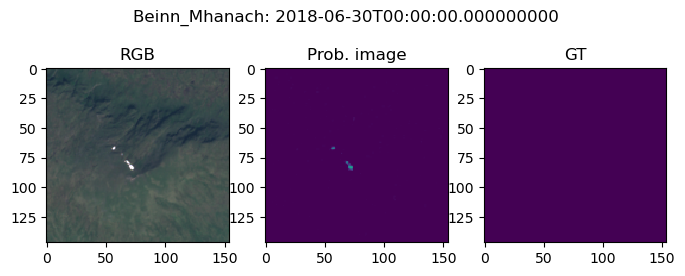

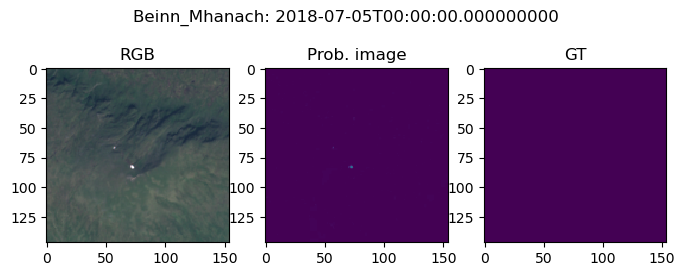

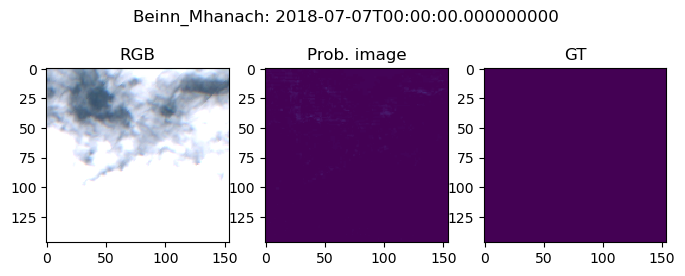

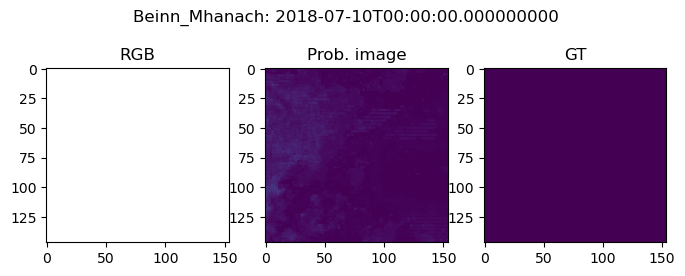

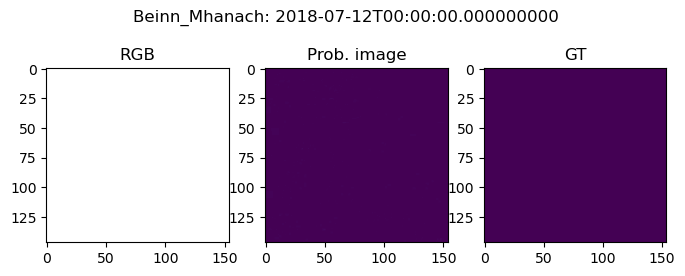

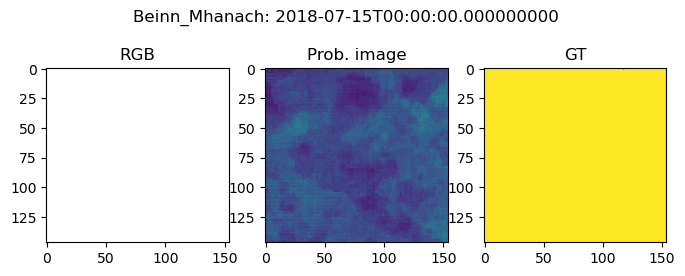

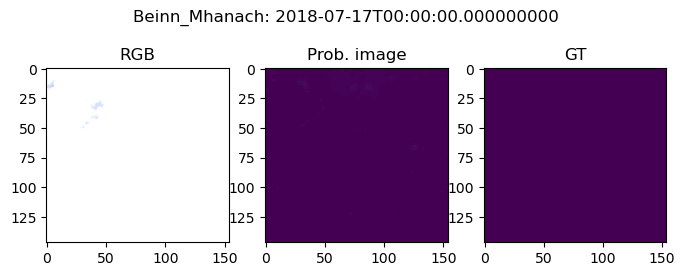

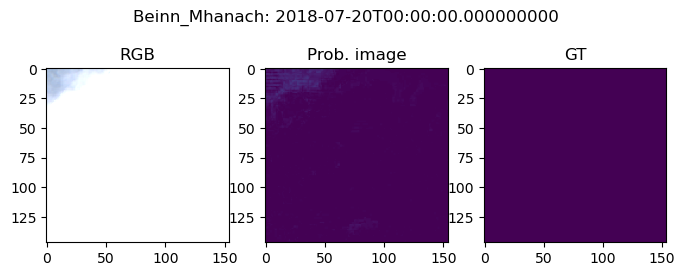

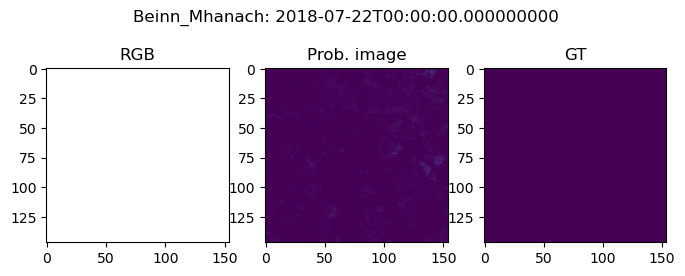

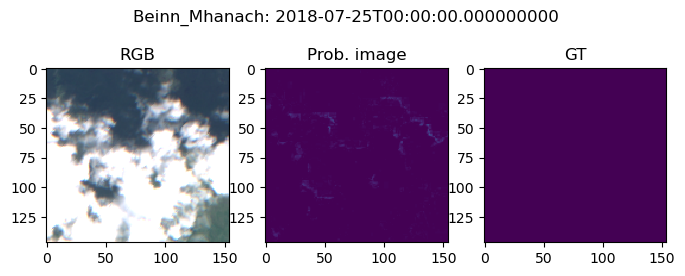

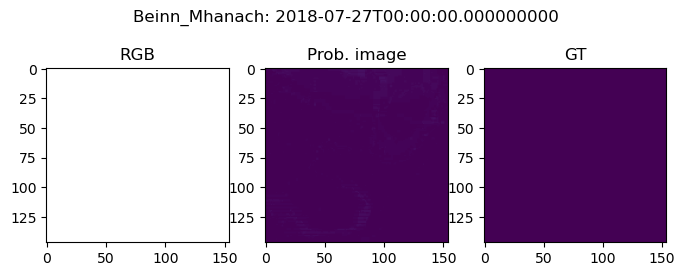

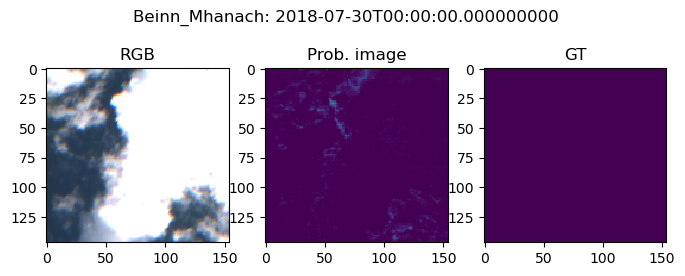

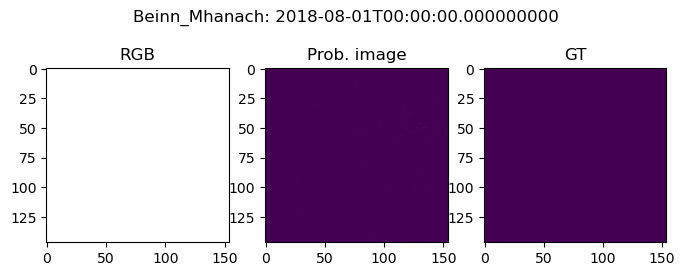

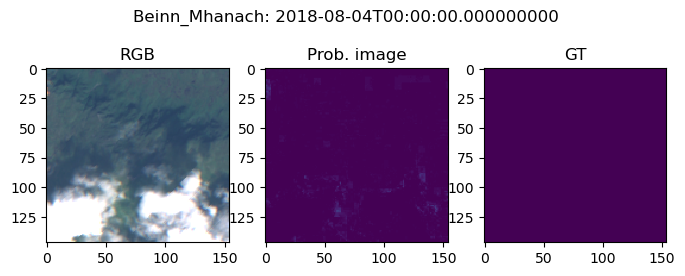

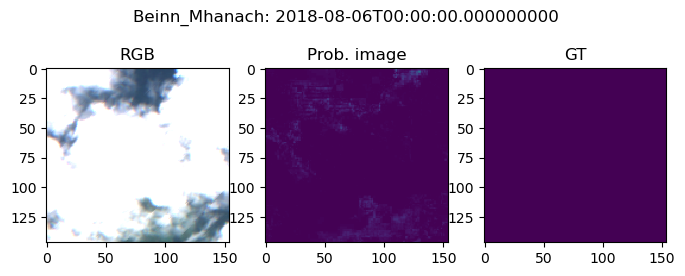

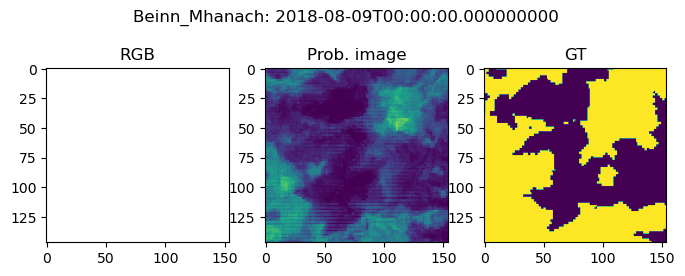

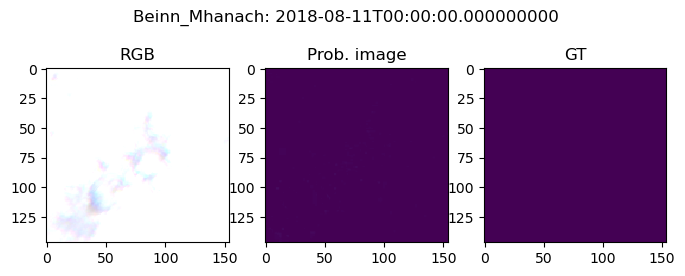

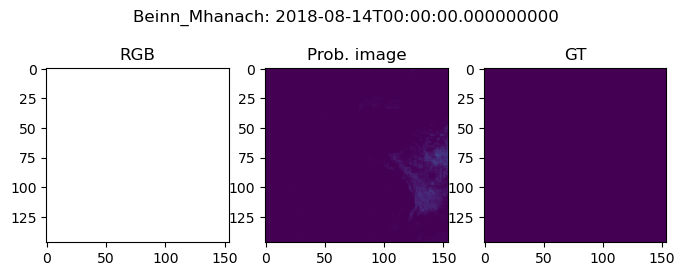

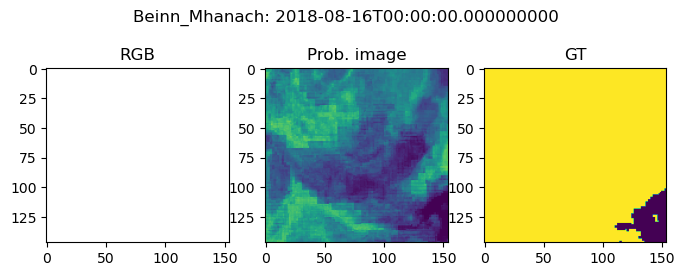

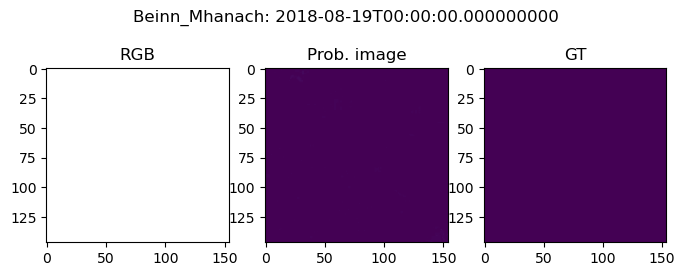

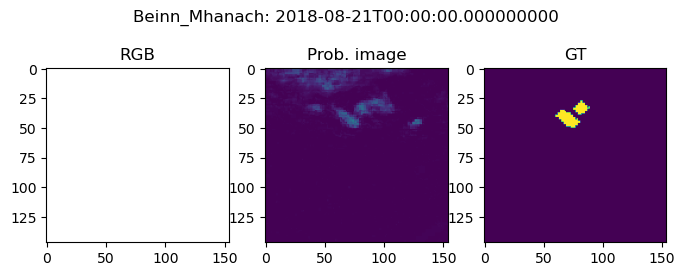

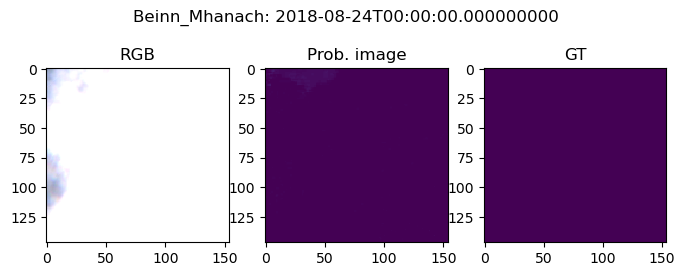

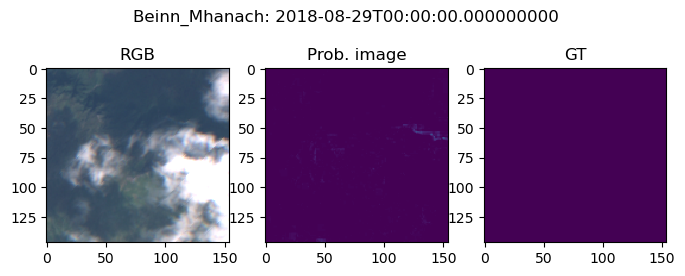

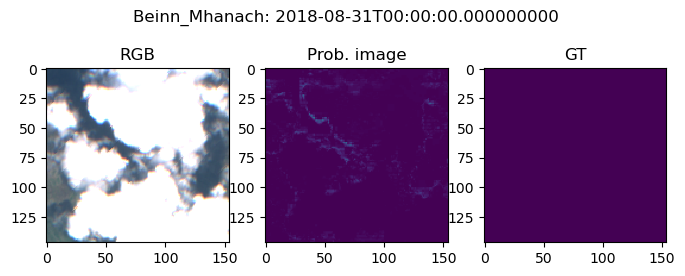

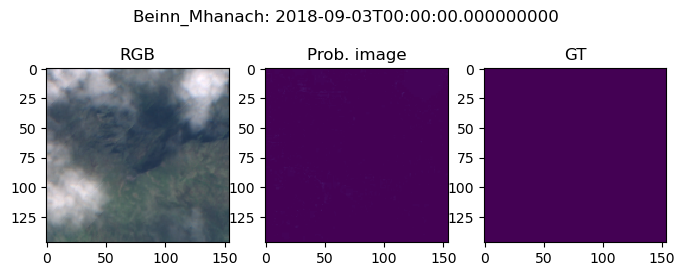

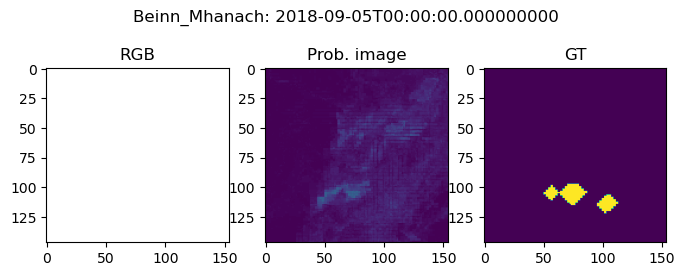

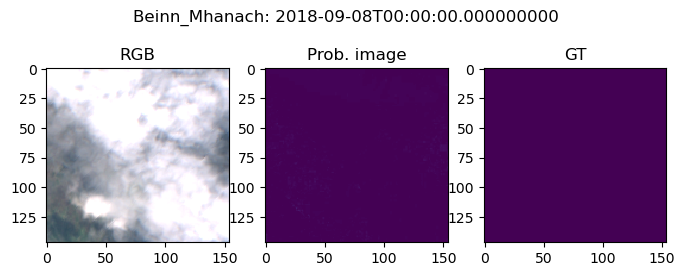

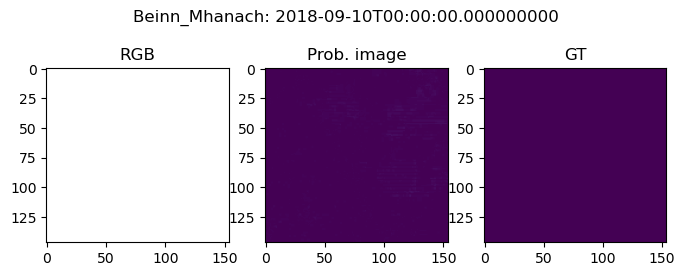

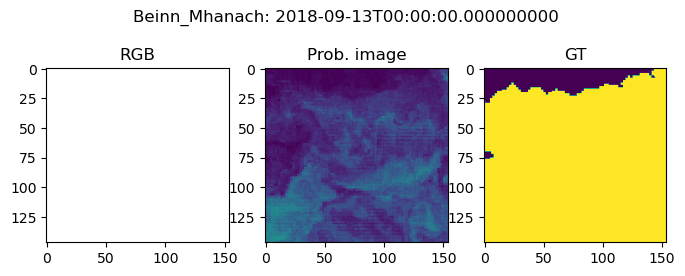

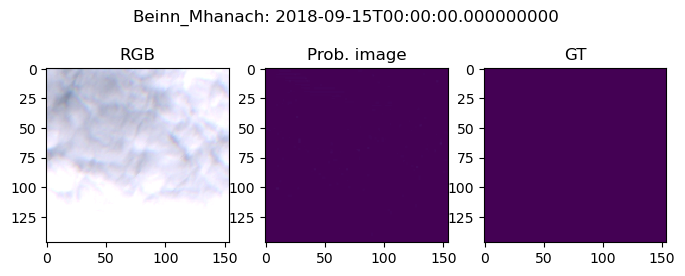

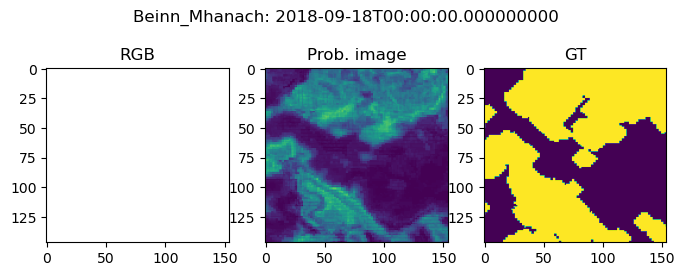

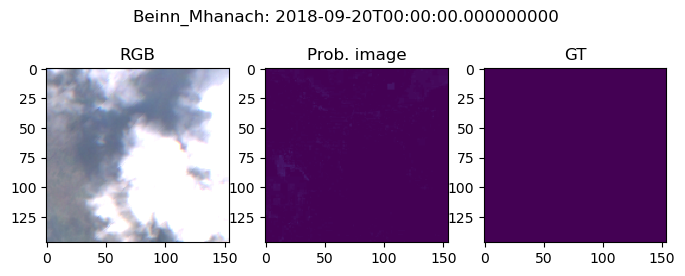

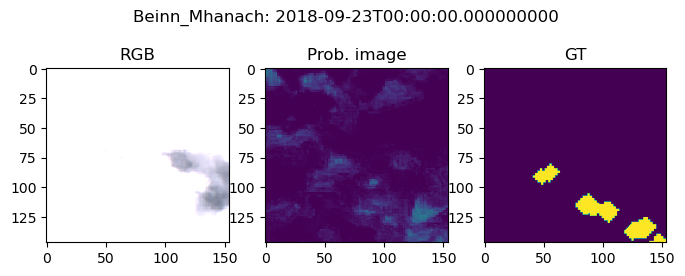

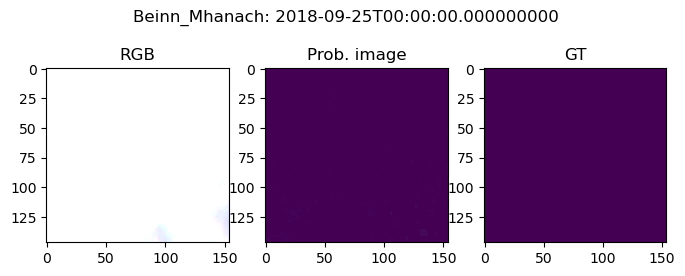

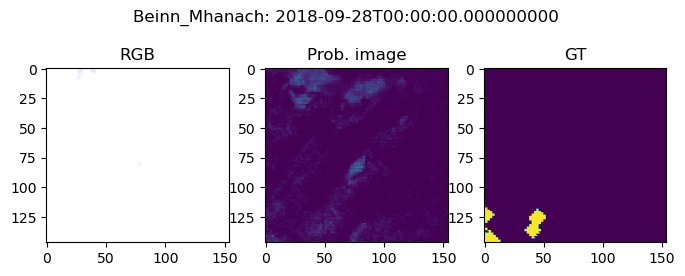

In [115]:
for p1 in test_path_list[:1]:
    ds = xr.open_dataset(p1)

    for t in ds.t:
    
        ds_features = ds[feature_bands]
        imStack = ds_features.sel(t=t).to_array().values
    
        nb, nx, ny = imStack.shape
        featsOneIm = imStack.reshape(nb, -1)
        classified_image = cls.predict_proba(featsOneIm.T)[:,1]
        classified_image = classified_image.reshape(nx, ny)
    
        # Get the corresponding GT image.  This has 3 channels, we need the 1st, value 11 means snow.
        imGT = ds["SCL"].sel(t=t).values == 11
        
        # Now display three images:  RGB image, probability image, GT image
        fig = plt.figure(figsize=(8, 3))
        fig.suptitle(f"{ds.attrs['patchname']}: {t.date.values}")
        plt.subplot(1,3,1)
        plt.imshow(RGBfromStack13(imStack), interpolation='nearest')
        plt.title("RGB")
        plt.subplot(1,3,2)
        plt.imshow(classified_image, vmin=0, vmax=1)
        plt.title("Prob. image")
        plt.subplot(1,3,3)
        plt.imshow(imGT)
        plt.title("GT")
        plt.show()